In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import os
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [1]:
import csv
def clean_csv(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        for row in reader:
            # Attempt to fix rows by replacing problematic characters or reformatting
            new_row = [field.replace('\n', ' ').replace('\r', '') for field in row]
            writer.writerow(new_row)

clean_csv('dataset_tweets_preprocessed2.csv', 'cleaned_dataset.csv')
df = pd.read_csv('cleaned_dataset.csv', on_bad_lines='skip')

Error: field larger than field limit (131072)

# FeedForward Neural Network

In [26]:
class SparseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_tensor = torch.FloatTensor(self.X[idx].toarray().squeeze(0))
        y_tensor = torch.tensor(self.y.iloc[idx], dtype=torch.long)
        return x_tensor, y_tensor

class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(TextClassifier, self).__init__()
        layers = []
        in_features = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_features, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(0.5))
            in_features = hidden_dim
        layers.append(nn.Linear(in_features, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20):
    model.train()
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                v_loss = criterion(outputs, labels)
                val_loss += v_loss.item()

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            print("Validation loss did not improve, stopping...")
            break

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

def evaluate_model(model, test_loader, device):
    model.eval()
    y_all_preds = []
    y_all_tests = []
    y_scores = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_scores.extend(probabilities[:, 1].tolist())
            y_all_preds.extend(predicted.tolist())
            y_all_tests.extend(labels.tolist())

    accuracy = accuracy_score(y_all_tests, y_all_preds)
    precision = precision_score(y_all_tests, y_all_preds, average='binary')
    recall = recall_score(y_all_tests, y_all_preds, average='binary')
    f1 = f1_score(y_all_tests, y_all_preds, average='binary')

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    return y_all_preds, y_scores, y_all_tests, metrics

def plot_roc_curve(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [27]:
df = pd.read_csv('dataset_tweets_preprocessed2.csv')
df['target'] = df['target'].apply(lambda x: 0 if x==0 else 1)
df['processed_text_str'] = df['processed_text_str'].astype(str)
texts = df['processed_text_str']
labels = df['target']

Epoch [1/20], Loss: 0.4743, Val Loss: 0.4407
Epoch [2/20], Loss: 0.4254, Val Loss: 0.4315
Validation loss did not improve, stopping...
{'accuracy': 0.801890625, 'precision': 0.8088477562573546, 'recall': 0.7922632175744209, 'f1_score': 0.8004695943925646}


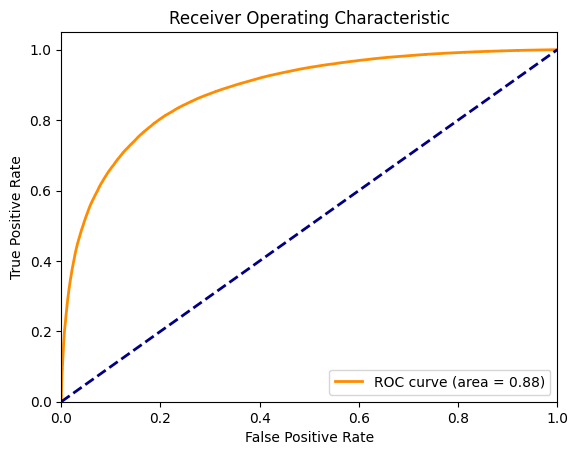

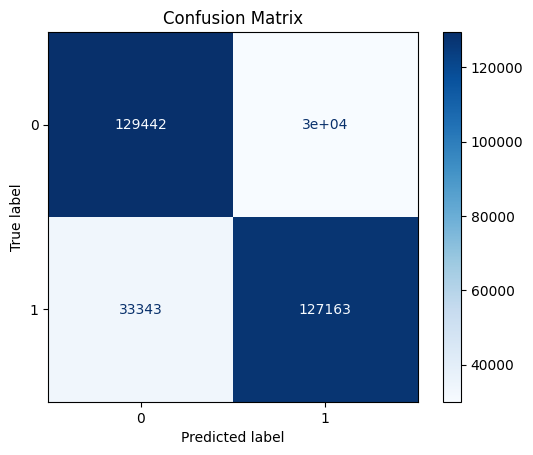

In [28]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x==0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)
    texts = df['processed_text_str']
    labels = df['target']

    vectorizer_bow = CountVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer_bow.fit_transform(texts)
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    train_dataset = SparseDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = SparseDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TextClassifier(10000, [256, 128], 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)
    predictions, scores, test_labels, performance_metrics = evaluate_model(model, test_loader, device)
    print(performance_metrics)
    
    plot_roc_curve(test_labels, scores)
    plot_confusion_matrix(test_labels, predictions)

In [29]:
torch.save(model, 'BoW_FFNN_model.pth')

## ---------------------------- BoW with FeedForward Neural Network ---------------------------- 

- accuracy: 0.801659375

- precision: 0.8134614266424607

- recall : 0.7844566558259505

- f1_score: 0.7986957997266001

Epoch [1/20], Loss: 0.4741, Val Loss: 0.4467
Epoch [2/20], Loss: 0.4296, Val Loss: 0.4300
Epoch [3/20], Loss: 0.4007, Val Loss: 0.4296
Validation loss did not improve, stopping...
{'accuracy': 0.798809375, 'precision': 0.8057663801713882, 'recall': 0.7891044571542497, 'f1_score': 0.797348383502312}


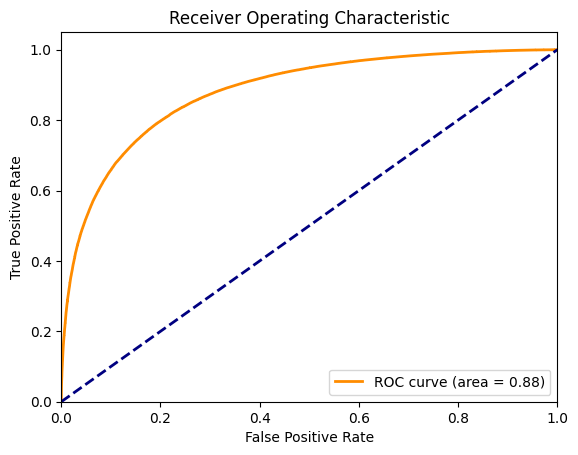

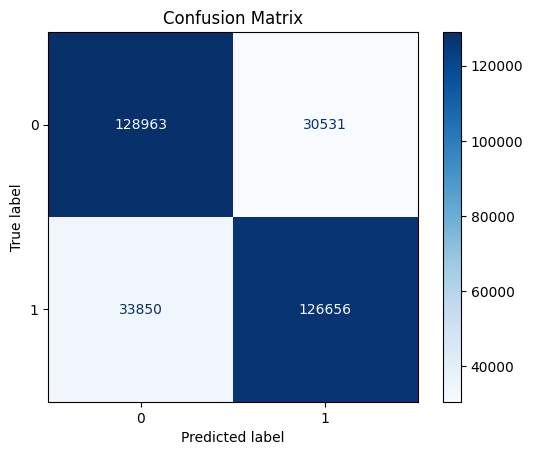

In [30]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x==0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)
    texts = df['processed_text_str']
    labels = df['target']

    tfidf_vectorizer  = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = tfidf_vectorizer.fit_transform(texts)
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    train_dataset = SparseDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = SparseDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TextClassifier(10000, [256, 128], 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)
    torch.save(model, 'TFIDF_FFNN_model.pth')

    predictions, scores, test_labels, performance_metrics = evaluate_model(model, test_loader, device)
    print(performance_metrics)
    
    plot_roc_curve(test_labels, scores)
    plot_confusion_matrix(test_labels, predictions)

## ---------------------------- TF-IDF with FeedForward Neural Network ---------------------------- 

- accuracy: 0.800615625

- precision: 0.7868691003803049

- recall: 0.8262993283740172

- f1_score: 0.8061023233198097

# Bidirectional Encoder Representations from Transformers

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle


# Define Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_attention_mask=True,
            truncation=True,
            padding='max_length',
            return_tensors="pt",
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_classes)
        
    def forward(self, input_ids, attention_mask, labels=None):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


# Data Loader Creation
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TextDataset(
        texts=df['text'].to_numpy(),
        labels=df['target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Evaluate Function
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=1)

            y_probs.extend(probabilities[:, 1].cpu().numpy())
            y_pred.extend(logits.argmax(dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, roc_auc, y_true, y_pred, y_probs


# Plot ROC Curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


# Main Training Loop
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs):
    scaler = GradScaler()
    best_accuracy = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for d in train_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss  # Extract the loss tensor explicitly

            scaler.scale(loss).backward()  # Scale the loss tensor
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # Evaluate the model on the validation set
        val_accuracy, val_precision, val_recall, val_f1, val_roc_auc, _, _, _ = evaluate_model(model, val_loader, device)

        scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

        # Save the model if validation accuracy improves
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'BERT_model.pth')
            print("Model saved!")

    print("Training complete!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\panha\AppData\Local\Temp\ipykernel_876\268972578.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\panha\AppData\Local\Temp\ipykernel_876\268972578.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('c

Epoch 1/5
Train Loss: 0.3942
Val Accuracy: 0.8313, Precision: 0.8562, Recall: 0.7975, F1: 0.8258, ROC-AUC: 0.9141
Model saved!


C:\Users\panha\AppData\Local\Temp\ipykernel_876\268972578.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/5
Train Loss: 0.3457
Val Accuracy: 0.8365, Precision: 0.8400, Recall: 0.8325, F1: 0.8362, ROC-AUC: 0.9170
Model saved!


C:\Users\panha\AppData\Local\Temp\ipykernel_876\268972578.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/5
Train Loss: 0.3022
Val Accuracy: 0.8335, Precision: 0.8368, Recall: 0.8299, F1: 0.8333, ROC-AUC: 0.9140


C:\Users\panha\AppData\Local\Temp\ipykernel_876\268972578.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/5
Train Loss: 0.2557
Val Accuracy: 0.8311, Precision: 0.8342, Recall: 0.8277, F1: 0.8309, ROC-AUC: 0.9104


C:\Users\panha\AppData\Local\Temp\ipykernel_876\268972578.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/5
Train Loss: 0.2143
Val Accuracy: 0.8274, Precision: 0.8353, Recall: 0.8169, F1: 0.8260, ROC-AUC: 0.9059
Training complete!
Test Accuracy: 0.8274, Precision: 0.8353, Recall: 0.8169, F1: 0.8260, ROC-AUC: 0.9059


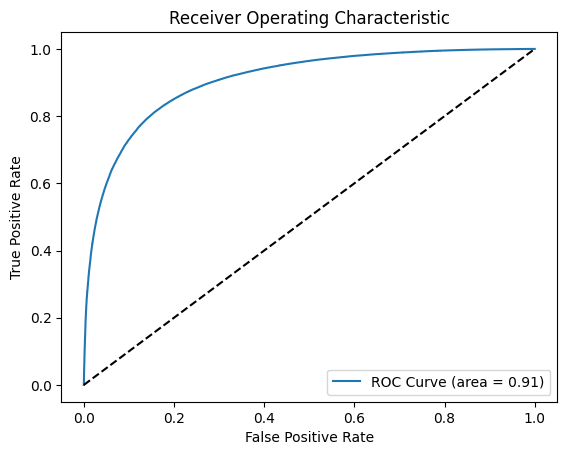

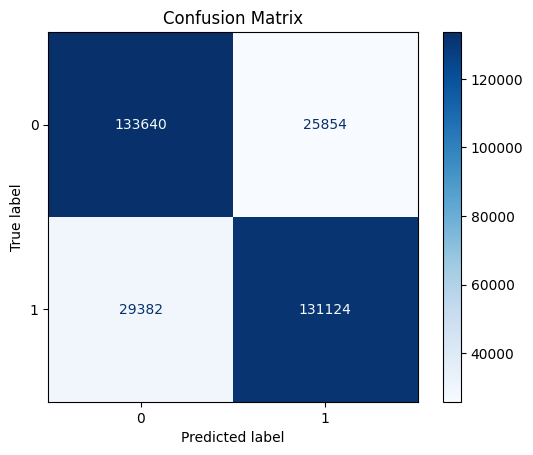

In [10]:
if __name__=='__main__':
    # Load and Prepare Data
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df = df.drop(columns=['processed_text_str'])

    # Train-Validation Split
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Hyperparameters
    MAX_LEN = 128
    BATCH_SIZE = 32
    EPOCHS = 5
    LEARNING_RATE = 2e-5

    # Tokenizer and DataLoader
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
    val_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

    # Model and Optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SentimentClassifier(n_classes=2).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Train Model
    train_model(model, train_loader, val_loader, optimizer, scheduler, device, EPOCHS)

    # Evaluate and Plot Results
    accuracy, precision, recall, f1, roc_auc, y_true, y_pred, y_probs = evaluate_model(model, val_loader, device)
    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    plot_roc_curve(y_true, y_probs)
    plot_confusion_matrix(y_true, y_pred)